### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #07

#### Name:

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy
import bci_classifiers2 as cfy2

In [2]:
def proc_spatialFilter(cnt, clab, chan, neighbors='*'):
    '''
    Usage:
        cnt_sf = proc_spatialFilter(cnt, clab, chan, neighbors='*')
    Parameters:
        cnt:       a 2D array of multi-channel timeseries (size: channels x samples),
        clab:      a 1D array of channel names  (size: channels)
        chan:      channel of center location
        neighbors: labels of channels that are to be subtracted 
    Returns:
        cnt_sf:    timeseries of spatially filtered channel (size: 1 x samples)
    Examples:
        cnt_c4_bip = proc_spatialFilter(cnt, clab, 'C4', 'CP4')
        cnt_c4_lap = proc_spatialFilter(cnt, clab, 'C4', ['C2','C6','FC4','CP4'])
        cnt_c4_car = proc_spatialFilter(cnt, clab, 'C4', '*')
    '''
    cidx= clab.index(chan)
    if isinstance(neighbors, list):
        nidx = [clab.index(cc) for cc in neighbors]
    elif neighbors == '*':
        nidx = range(len(clab))   # Common Average Reference (CAR)
    else:
        nidx = [clab.index(neighbors)]
    cnt_sf = cnt[[cidx],:] - np.mean(cnt[nidx,:], axis=0)
    return cnt_sf

## Preparation: Load data

In [3]:
fname = 'imagVPaw.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Determining a Frequency Band  (6 points)
Calculate the classwise averaged power spectral density (PSD) at scalp locations C3 and C4 in the data set `imagVPaw`. For each motor imagery condition, you may use the interval 1000-5000 ms.  Determine a frequency band that seems useful to discriminate the two moto imagery conditions.
**Note:** To take into account what was said in the lecture about spectra and spatial filtering, use a bipolar filter for C3 and a Laplace filter for C4. To calculate the average spectra over single trials you can use 

```>>> f, psd = sp.signal.welch(X.flatten('F'), fs=100)```
  
assuming the single trials of one channel to be the columns of `X` and sampled at 100Hz.

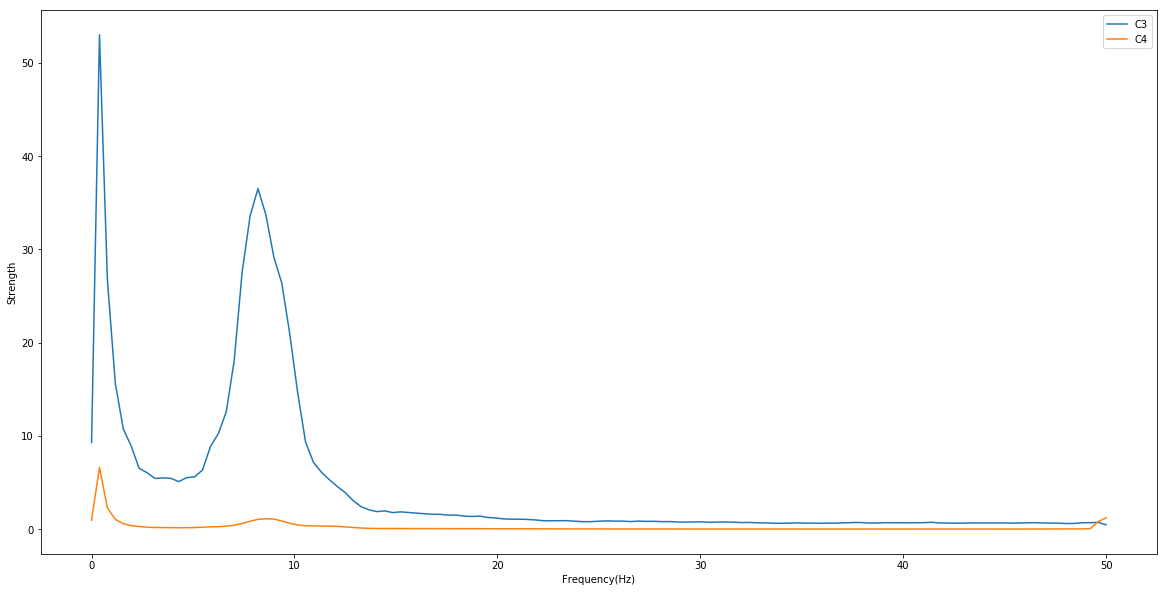

The most usefull band seems to be 8-12 Hz


In [4]:
neighboursC4 = ['C2','C6','FC4','CP4']
ival = [1000,5000]

filteredC3 = proc_spatialFilter(cnt, clab, 'C3', 'C4')
filteredC4 = proc_spatialFilter(cnt, clab, 'C4', neighboursC4)

epoC3, epo_tC3 = bci.makeepochs(filteredC3, fs, mrk_pos, ival)
epoC4, epo_tC4 = bci.makeepochs(filteredC4, fs, mrk_pos, ival)

fC3, psdC3 = sp.signal.welch(epoC3.flatten('F'),fs=fs)
fC4, psdC4 = sp.signal.welch(epoC4.flatten('F'),fs=fs)

plt.figure(figsize=(20,10))
plt.ylabel("Strength")
plt.xlabel("Frequency(Hz)")
plt.plot(fC3,psdC3, label="C3")
plt.plot(fC4,psdC4, label="C4")
plt.legend()
plt.show()
print("The most usefull band seems to be 8-12 Hz")

## Exercise 2: Visualizing ERD/ERS curves  (4 points)
Design a band-pass filter with the frequency band that was selected in exercises \#1 (use the band `[11. 16.]` if you did not succeed with that, but note that this band may be suboptimal). For the same channels (and spatial filters) as in exercise \#1, calculate and display the classwise averaged ERD/ERS curves with respect to the determined frequency band for the time interval that encompasses a prestimulus interval of 500 ms and extends to 6000 ms poststimulus.

(651, 1, 280)
(651, 1, 140)


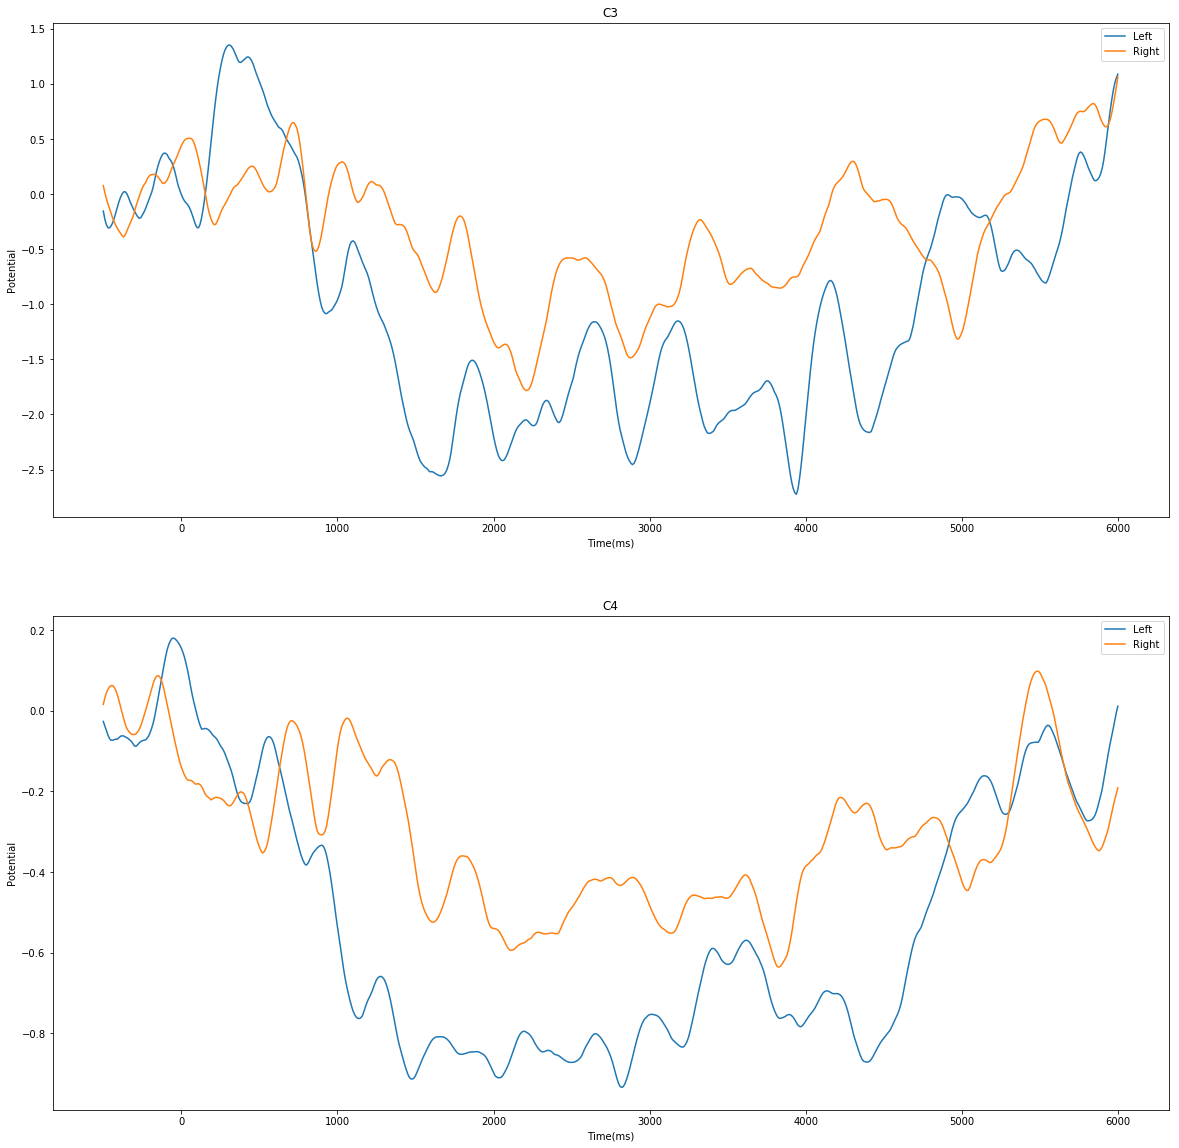

In [5]:
ival = [-500,6000]
ref_ival = [-500,0]
ws = fs*2*np.pi
band = [((8*2*np.pi)/(.5*ws)), ((12*2*np.pi)/(.5*ws))]

b, a = sp.signal.butter(10, band, btype="bandpass")

c3_filter = sp.signal.lfilter(b,a,filteredC3)
c4_filter = sp.signal.lfilter(b,a,filteredC4)

c3_filter = np.abs(sp.signal.hilbert(c3_filter, axis=1))
c4_filter = np.abs(sp.signal.hilbert(c4_filter, axis=1))

epoC3, epo_tC3 = bci.makeepochs(c3_filter, fs, mrk_pos, ival)
epoC4, epo_tC4 = bci.makeepochs(c4_filter, fs, mrk_pos, ival)

epoC3 = bci.baseline(epoC3, epo_tC3, ref_ival)
epoC4 = bci.baseline(epoC4, epo_tC4, ref_ival)

print(epoC3.shape)
print(epoC3[:,:,mrk_class==1].shape)

plt.figure(figsize=(20,20))

avgC3_0 = np.average(epoC3[:,:,mrk_class==0], axis=2)
avgC4_0 = np.average(epoC4[:,:,mrk_class==0], axis=2)

avgC3_1 = np.average(epoC3[:,:,mrk_class==1], axis=2)
avgC4_1 = np.average(epoC4[:,:,mrk_class==1], axis=2)

plt.subplot(2,1,1)

plt.title("C3")
plt.xlabel("Time(ms)")
plt.ylabel("Potential")
plt.plot(epo_tC3,avgC3_0, label="Left")
plt.plot(epo_tC3,avgC3_1, label="Right")
plt.legend()

plt.subplot(2,1,2)

plt.title("C4")
plt.xlabel("Time(ms)")
plt.ylabel("Potential")
plt.plot(epo_tC4,avgC4_0, label="Left")
plt.plot(epo_tC4,avgC4_1, label="Right")
plt.legend()

## Exercise 3: Classification of single-trial ERD/ERS curves  (5 points)
Subsample the band-pass filtered and rectified epochs of the interval 1000 ms to 5000 ms down to 5 Hz by calculating the average of every consequtive window of 200 ms. Perform crossvalidation of those features separately for each single channel and display the result as scalp map. (In this case, do not use a spatial filter.) Furthermore, perform a 3-fold crossvalidation for the joint feature vector (dimensionality is 20 [time points] `x` 51 [channels]).
**Note:** Don't be disappointed if the results are not good. On the next sheet you will implement a powerful method for this case.

Result of cross validation of avarage vector:
 45.7 +/- 5.0  (training: 21.6 +/- 5.3)  [using train_LDA]


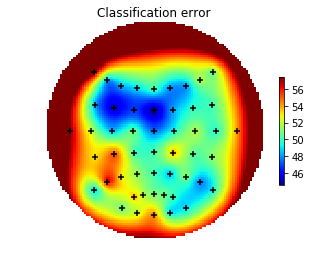

In [6]:
ival = [-500,5000]
ref_ival = [-500,0]
ws = fs*2*np.pi
band = [((8*2*np.pi)/(.5*ws)), ((12*2*np.pi)/(.5*ws))]

b, a = sp.signal.butter(10, band, btype="bandpass")

cnt_filter = sp.signal.lfilter(b,a,cnt)

epo, epo_t = bci.makeepochs(cnt_filter, fs, mrk_pos, ival)
epo = bci.baseline(epo, epo_t, ref_ival)
epo = epo[150:550,:,:]
epo = np.reshape(epo,(20,20,51,-1))
epo = np.average(epo,axis=0)

results = np.zeros(51)

for i in range(51):
    loss_te, loss_tr = cfy.crossvalidation(cfy.train_LDA,epo[:,i,:],mrk_class,verbose=False)
    results[i] = loss_te

plt.title("Classification error")
bci.scalpmap(mnt,results)

epo = np.average(epo,axis=2)
print("Result of cross validation of avarage vector:")
loss_te, loss_tr = cfy.crossvalidation(cfy.train_LDA,epo[:,:],mrk_class,verbose=True,folds=3)